# Booking Hotels Scrapper

GROUP 8:  Viktoriia Yuzkiv, Sebastien Boxho, Arianna Michelangelo

This notebook includes the pipeline to scrape Booking.com listings data and saves the data into a csv file.


Cities:
- Barcelona
- Marseille
- Valencia
- Porto

Dates:
- MWC Barcelona: 26 - 29 February 2024 (selected period: 23 Feb - 3 Mar)
- The second period: March 8 - 17th

### Paths

In [1]:
# This cell is for the path configuration (relative to the notebook)

# Path to your geckodriver file - please change to your path before running the code
geko_path = 'C:/Users/School/Downloads/geckodriver-v0.34.0-win64/geckodriver.exe' 

# Please change to your profile path (if you have one Firefox profile)
profile_path = '/Users/viktoriia/Library/Application Support/Firefox/Profiles/k7kr4dw0.Viktoriia' 

# Booking link
link = 'https://www.booking.com/index.en-gb.html'

### Import libraries

In [2]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import NoSuchElementException

import os
import re
import time
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.api as smf
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor

import src.booking_scrapper as bs
import src.description_analysis as da

## Part 1: Hotel Scrapper

This section of the notebook uses the booking_scrapper.py file to scrap the intended data from Booking.com in the given city and time period

In [18]:
# Select Cities: List of cities to search examples: ['Barcelona','Marseille','Valencia','Porto']
cities = ['Barcelona']

# Select start and end dates: Format YYYY-MM-DD
start_date = '2024-03-08'
end_date = '2024-03-17'

# Select intervall: Number of days for each interval. If None, get prices for the entire range.
intervall = 1

# Select page limit: Number of pages to scrape for each city. If None, scrape all pages.
p_limit = 5

In [19]:
def scrape_data(cities, start_date, end_date, interval=None, page_limit=None):
    """
    Scrapes hotel data for the specified cities and date range.

    Parameters:
    - cities: List of cities to scrape data for.
    - start_date: Start date in the format 'YYYY-MM-DD'.
    - end_date: End date in the format 'YYYY-MM-DD'.
    - interval: Number of days for each interval. If None, get prices for the entire range.

    Returns:
    - DataFrame containing scraped data with columns: 'City', 'Start_Date', 'End_Date', 'Hotel_Name', 'Price', 'Hotel_Description_Short', 'Rating', 'url'.
    """
    scrapper = bs.Booking_Scrapper()
    # Validate input
    try:
        if not scrapper.check_date_format(start_date) or not scrapper.check_date_format(end_date):
            raise ValueError("Invalid date format. Please use 'YYYY-MM-DD'.")
    except ValueError as e:
        print(e)

    
    if interval is not None and not isinstance(interval, int):
        raise ValueError("Interval should be an integer or None.")

    # Initialize an empty DataFrame to store the results
    result_df = pd.DataFrame(columns=['City', 'Start_Date', 'End_Date', 'Hotel_Name', 'Price', 'Hotel_Description_Short', 'Rating', 'url'])

    # If you have a Firefox profile with ad-blocker, please add your profile_path here.
    # Otherwise, no changes in the code are needed, but the Google pop-up will have to be closed manually.
    browser = scrapper.start_up(link, geko_path)

    # Date in datetime format
    s_d = datetime.strptime(start_date, '%Y-%m-%d')
    e_d = datetime.strptime(end_date, '%Y-%m-%d')

    # Iterate over cities
    for city in cities:        
        c_d = s_d

        print("City: ", city)

        # If statment if first loof of the for loop
        if city == cities[0]:   
            # Check for the pop up on the first page and close it if it appears
            scrapper.check_and_click(browser, '.f4552b6561', 'css')

            # Google pop-up
            scrapper.check_and_click(browser, '/html/body/div/div[1]/div/div[1]/div[2]/svg', 'xpath') 
        
        # Choose the place
        scrapper.select_place(browser, city)

        # Iterate over date intervals
        while c_d < e_d:

            time.sleep(1)
            # Calculate the end date of the current interval
            i_e_d = min(c_d + timedelta(days=interval), e_d) if interval is not None else e_d
            # Call scraping function with the current date range
            interval_end_date = i_e_d.strftime('%Y-%m-%d')
            current_date = c_d.strftime('%Y-%m-%d')
            print("Current date: ", current_date)
            print("Interval end date: ", interval_end_date)
            scrapper.select_dates(browser, current_date, interval_end_date)

            # Click on the search button
            if c_d == s_d:
                my_xpath='/html/body/div[3]/div[2]/div/form/div[1]/div[4]/button/span'
                scrapper.check_and_click(browser,my_xpath , type='xpath')
            else:
                my_xpath='/html/body/div[4]/div/div[2]/div/div[1]/div/form/div[1]/div[4]/button/span'
                scrapper.check_and_click(browser,my_xpath , type='xpath')
            
        
            time.sleep(2)

            # Click on the other pop up
            scrapper.check_and_click(browser, 'div.cc1b961f14:nth-child(1) > button:nth-child(1)', 'css')
            
            # Get the number of pages
            pages = scrapper.get_number_pages(browser)
            
            page_stop = min(pages, page_limit) if page_limit is not None else pages
            for p in range(page_stop-1):
                print("Page: ", p+1)
                df_temp = pd.DataFrame(scrapper.get_hotels(browser))
                df_temp['City'] = city
                df_temp['Start_Date'] = current_date
                df_temp['End_Date'] = interval_end_date
                
                # Append the results to the DataFrame
                print("Length of the DataFrame: ", len(result_df))
                result_df = pd.concat([result_df, df_temp], ignore_index=True)
                time.sleep(3)
                # Click on the next button
                if p < page_stop-1:
                    css = 'div.b16a89683f:nth-child(3) > button:nth-child(1)'
                    browser.find_element('css selector',css).click() 
                    time.sleep(2)
                else:
                    break

                print("After, Start_date: ", s_d, "End_date: ", e_d, "Current_date: ", c_d, "Interval_end_date: ", i_e_d)
            # Move to the next interval
            c_d = i_e_d
        
        # Go back to the main page
        scrapper.start_up(link, geko_path, browser=browser)
    
    browser.quit()

    return result_df

df = scrape_data(cities, start_date, end_date, intervall, p_limit)

City:  Barcelona
Current date:  2024-03-08
Interval end date:  2024-03-09
Search Button
Page:  1
Length of the DataFrame:  0
After, Start_date:  2024-03-08 00:00:00 End_date:  2024-03-17 00:00:00 Current_date:  2024-03-08 00:00:00 Interval_end_date:  2024-03-09 00:00:00
Page:  2
Length of the DataFrame:  26
After, Start_date:  2024-03-08 00:00:00 End_date:  2024-03-17 00:00:00 Current_date:  2024-03-08 00:00:00 Interval_end_date:  2024-03-09 00:00:00
Page:  3
Length of the DataFrame:  51
After, Start_date:  2024-03-08 00:00:00 End_date:  2024-03-17 00:00:00 Current_date:  2024-03-08 00:00:00 Interval_end_date:  2024-03-09 00:00:00
Page:  4
Length of the DataFrame:  76
After, Start_date:  2024-03-08 00:00:00 End_date:  2024-03-17 00:00:00 Current_date:  2024-03-08 00:00:00 Interval_end_date:  2024-03-09 00:00:00
Current date:  2024-03-09
Interval end date:  2024-03-10
Search Button _ 2
Page:  1
Length of the DataFrame:  101
After, Start_date:  2024-03-08 00:00:00 End_date:  2024-03-17 0

In [20]:
def save_dataframe_to_csv(df, city, start_date, end_date, interval_days=None):
    # Convert city to a string if it's a list
    if isinstance(city, list):
        city_name = '_'.join(city)
    else:
        city_name = str(city)

    # Build the file name
    file_name_parts = [city_name, start_date, end_date]
    if interval_days is not None:
        file_name_parts.append(f"{interval_days}_days")
    
    file_name = '_'.join(file_name_parts) + '.csv'
    
    # Ensure the 'data' folder exists
    if not os.path.exists('data'):
        os.makedirs('data')

    # Save DataFrame to CSV
    df.to_csv(os.path.join('data', file_name), index=False)

save_dataframe_to_csv(df, cities, start_date, end_date, intervall)

In [28]:
print("Length dataframe: ",len(df))
print("Cities: ", df['City'].unique())
print("Hotel Names: ", len(df['Hotel_Name'].unique()))
print("Start_dates: ",len(df['Start_Date'].unique()))   
print("End_dates: ",len(df['End_Date'].unique()))  

909
Cities:  ['Barcelona']
Hotel Names:  203
Start_dates:  9
End_dates:  9


Download the descriptions of each hotel which is not already in the Hotel_Descriptions.csv file.

In [27]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/75.0.3770.142 Safari/537.36'}

def scrape_description(url):
    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status() 
        # time.sleep(0.5)
    except requests.exceptions.RequestException as e:
        print(f"Error processing {url}: {e}")
        return None

    soup = BeautifulSoup(response.text, 'html.parser')
    description_tag = soup.find('p', class_='a53cbfa6de b3efd73f69')

    if description_tag:
        return description_tag.get_text(strip=True)
    else:
        print(f"Description tag not found on the page: {url}")
        return None

def download_save_description_column(df):
    # Set the number of concurrent threads (adjust this based on the processing power of your computer)
    num_cpus = os.cpu_count()
    num_threads = max(4, num_cpus - 1)

    df_des = df[['City','Hotel_Name','url']].copy()

    # Drop duplicates
    df_des.drop_duplicates(subset=['Hotel_Name'], inplace=True)

    # If it exist open dataset of descriptions of the city
    if os.path.exists('data/Hotel_Descriptions.csv'):
        df_description = pd.read_csv('data/Hotel_Descriptions.csv')
        print("Hotel_Descriptions.csv exists with length: ", len(df_description), " new length: ", len(df_des))
        df_description.drop_duplicates(subset=['Hotel_Name'], inplace=True)
        df_des = df_des[~df_des['Hotel_Name'].isin(df_description['Hotel_Name'])]
        print("After dropping duplicates: ", len(df_des))
    
    # Create a ThreadPoolExecutor to run operations in parallel
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Use executor.map to apply the scrape_description function to each URL in parallel
        descriptions = []
        for i, description in enumerate(executor.map(scrape_description, df_des['url']), start=1):
            descriptions.append(description)
            # Print every 50 link to check the progess of the scraping
            if i % 50 == 0:
                print(f"Scraped {i} links")

    # Add  descriptions to the 'description' column in the df
    df_des['Hotel_Description_Long'] = descriptions

    # Merge the new descriptions with the existing ones
    if os.path.exists('data/Hotel_Descriptions.csv'):
        df_description = pd.read_csv('data/Hotel_Descriptions.csv')
        df_description = pd.concat([df_description, df_des], ignore_index=True)
    else:
        df_description = df_des

    # Save the descriptions to a CSV file
    print("Lenth of the new dataset: ", len(df_description))
    df_description.to_csv('data/Hotel_Descriptions.csv', index=False)
    
    return df_description

df_description = download_save_description_column(df)
df_description.head()


Hotel_Descriptions.csv exists with length:  315  new length:  259
After dropping duplicates:  0
Lenth of the new dataset:  315


,City,Hotel_Name,url,Hotel_Description_Long
0,Barcelona,Magatzem 128,https://www.booking.com/hotel/es/b-amp-b-magat...,"Offering city views, Magatzem 128 is an accomm..."
1,Barcelona,H La Paloma Adults Only,https://www.booking.com/hotel/es/h-la-paloma.e...,The H La Paloma is located in the Raval neighb...
2,Barcelona,Hostal Europa,https://www.booking.com/hotel/es/hostal-europa...,This guest house is 100 metres from Liceu Metr...
3,Barcelona,Sixtytwo Hotel,https://www.booking.com/hotel/es/sixtytwo-barc...,Situated next to Barcelona’s Passeig de Gracia...
4,Barcelona,Hotel Acta Azul Barcelona,https://www.booking.com/hotel/es/hotelazulbarc...,Set just off Plaça d’Espanya and at the foot o...


In [23]:
df_description.shape

(56, 4)

# Part 2: Difference-in-differences (DiD)

**Treatment period:**
\begin{equation}
Y_{t} = \beta_0 + \beta_1 D_t + \varepsilon_{t}
\end{equation}

$Y_{t}$ is the price for observation $i$ in time period $t$, 
$D_i$ is a dummy variable that takes the value of 1 during the treatment period and 0 otherwise, and 
$\beta_1$ captures the average treatment effect over time

**Treatment city:**
\begin{equation}
Y_{i} = \beta_0 + \beta_2 T_i + \varepsilon_{i}
\end{equation}

$T_i$ is a dummy variable that takes the value of 1 for the treatment city and 0 otherwise, 
$\beta_2$ captures the average difference in prices between the treatment city and the control cities

**Both (final equation):**
\begin{equation}
Y_{it} = \beta_0 + \beta_1 D_t + \beta_2 T_i + \alpha D_t T_i + \varepsilon_{it}
\end{equation}

$T_i$ is the treatment period dummy,
$D_i$ is the treatment city, 
$\alpha$ is the one that captures the DiD estimate, which is the differential change in prices for the treatment group compared to the control group, and
where $T_i = 1$ if individual $i$ is treatment period $t=1$ and $T_i=0$ otherwise


**Why use a second city**

The second city plays the role of a control group which is crucial for DiD analysis because it helps control for time-invariant unobserved factors that may affect prices in both the treatment and control groups. The key assumption in a DiD analysis is the parallel trends assumption, which implies that, in the absence of the treatment, the average outcomes for the treatment and control groups would follow parallel paths over time. Violation of this assumption could lead to biased estimates.


**Why $\alpha$ captures the treatment effect:**

If $\alpha$ is statistically significant and positive, it suggests that the treatment (event) had a differential impact on prices in the treatment city compared to the control cities. This coefficient captures the average treatment effect on prices that cannot be explained by time trends or differences between the treatment and control cities.



In [57]:
def openbarcelona(path):
    ''' Function to open 2 dataframes:
    - df1 which is the df of Barcelona the week of the event 
    - df2 which is the df of Barcelona another random no-event week
    '''
    df1 = pd.read_csv(path + '/barcelona_p1.csv')
    df2 = pd.read_csv(path + '/barcelona_p2.csv')
    return df1, df2

def choosecity(path, city):
    ''' Function to open 2 dataframes:
    - df1 which is the df of the choosen city the week of the event 
    - df2 which is the df of the choosen city another random no-event week
    '''
    df3 = pd.read_csv(path + city + '_p1.csv')
    df4 = pd.read_csv(path + city + '_p2.csv')
    return df3, df4

In [58]:
# Load the data
df1, df2 = openbarcelona('data/')
#Put the city all in low case
df3, df4 = choosecity('data/', 'marseille') 

In [59]:
# Eliminate the euro sign from the price feature and then transforming from object to numeric
df1['price'] = pd.to_numeric(df1['price'].replace('[^\d]', '', regex=True))
df2['price'] = pd.to_numeric(df2['price'].replace('[^\d]', '', regex=True))
df3['price'] = pd.to_numeric(df3['price'].replace('[^\d]', '', regex=True))
df4['price'] = pd.to_numeric(df4['price'].replace('[^\d]', '', regex=True))

In [60]:
df1.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description
0,0,Barcelona,2024-02-23,2024-03-03,Duquesa Suites Barcelona,3491,NaN,8.8,https://www.booking.com/hotel/es/duquesa-suite...,"Set the centre of Barcelona, 400 metres from P..."
1,1,Barcelona,2024-02-23,2024-03-03,Sonder Casa Luz,4457,NaN,8.4,https://www.booking.com/hotel/es/casa-luz-barc...,"Set in Barcelona, Sonder Casa Luz offers a ter..."
2,2,Barcelona,2024-02-23,2024-03-03,Valencia 2,1395,NaN,NaN,https://www.booking.com/hotel/es/valencia-2.en...,"Located in Barcelona, 1.2 km from Passeig de G..."
3,3,Barcelona,2024-02-23,2024-03-03,Fuster Apartments by Aspasios,2448,Entire apartment • 2 bedrooms • 1 living room ...,9.2,https://www.booking.com/hotel/es/fuster-apartm...,Fuster Apartments are just 150 metres from Dia...
4,4,Barcelona,2024-02-23,2024-03-03,BarcelonaForRent The Central Place,5350,Entire apartment • 1 bedroom • 1 living room •...,8.5,https://www.booking.com/hotel/es/barcelonaforr...,"Offering views of Casa Batlló, BarcelonaForRen..."


In [61]:
df1.describe()

,Unnamed: 0,price,rating
count,1001.000000,1001.000000,945.000000
mean,500.000000,3379.912088,7.852804
std,289.108111,1836.851740,1.127298
min,0.000000,601.000000,1.000000
25%,250.000000,2317.000000,7.300000
50%,500.000000,2999.000000,8.000000
75%,750.000000,3903.000000,8.500000
max,1000.000000,17158.000000,10.000000


In [62]:
df1.shape

(1001, 10)

In [63]:
#Creation of the dummy variables for the regression
# D is treatment period
# T is treatment city
df1['D'] = 1
df1['T'] = 1
df2['D'] = 0
df2['T'] = 1
df3['D'] = 1
df3['T'] = 0
df4['D'] = 0
df4['T'] = 0

In [64]:
#Removing outliers from prices to be plot better how is the data distributed. 
#But we are running the regressions with no outlier treatment
def remove_outliers(df, column, threshold=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    df_cleaned = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_cleaned

df32 = remove_outliers(df3, 'price')
df42 = remove_outliers(df4, 'price')
df12 = remove_outliers(df1, 'price')
df22 = remove_outliers(df2, 'price')

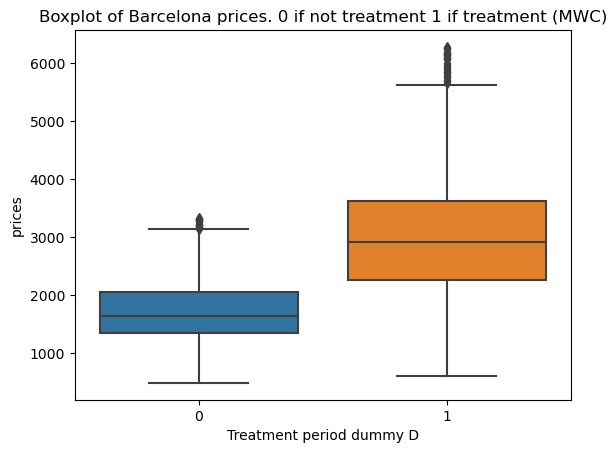

In [65]:
barcelona_df = pd.concat([df12, df22], ignore_index=True)

# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_df , x='D', y='price')
plt.title('Boxplot of Barcelona prices. 0 if not treatment 1 if treatment (MWC)')
plt.xlabel('Treatment period dummy D')
plt.ylabel('prices')
plt.show()

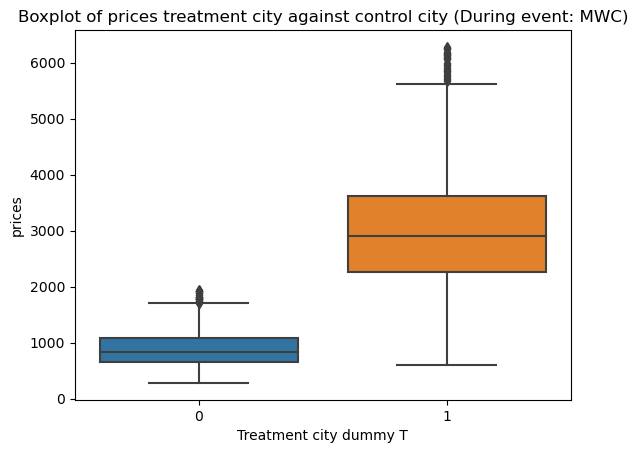

In [66]:
barcelona_city = pd.concat([df12, df32], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_city , x='T', y='price')
plt.title('Boxplot of prices treatment city against control city (During event: MWC)')
plt.xlabel('Treatment city dummy T')
plt.ylabel('prices')
plt.show()

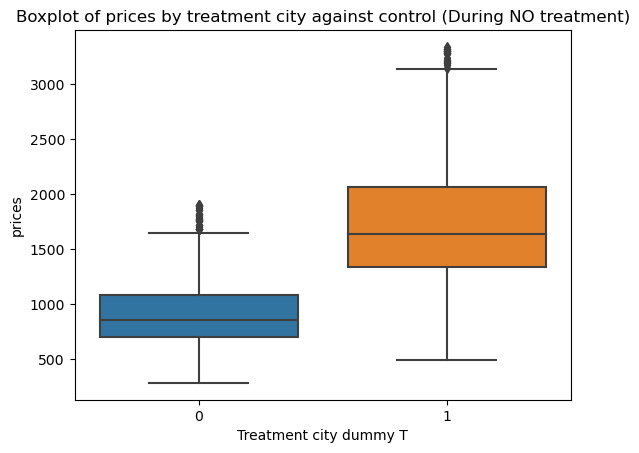

In [67]:
barcelona_cityNT = pd.concat([df22, df42], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=barcelona_cityNT , x='T', y='price')
plt.title('Boxplot of prices by treatment city against control (During NO treatment)')
plt.xlabel('Treatment city dummy T')
plt.ylabel('prices')
plt.show()

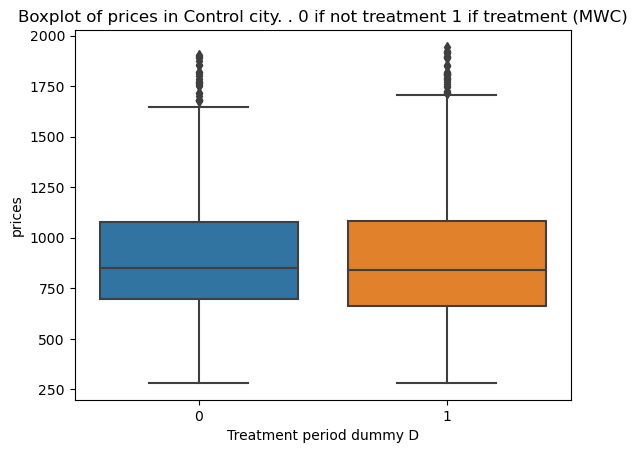

In [68]:
city = pd.concat([df32, df42], ignore_index=True)
# Plotting boxplot using seaborn
sns.boxplot(data=city , x='D', y='price')
plt.title('Boxplot of prices in Control city. . 0 if not treatment 1 if treatment (MWC)')
plt.xlabel('Treatment period dummy D')
plt.ylabel('prices')
plt.show()

In [69]:
#Creation of the big data frame
combined_df = pd.concat([df1, df2, df3, df4], ignore_index=True)
combined_df['T*D'] = combined_df['T'] * combined_df['D']
# Display the combined DataFrame
combined_df.head()

,Unnamed: 0,place,start_date,end_date,name,price,description_short,rating,url,description,D,T,T*D
0,0,Barcelona,2024-02-23,2024-03-03,Duquesa Suites Barcelona,3491,NaN,8.8,https://www.booking.com/hotel/es/duquesa-suite...,"Set the centre of Barcelona, 400 metres from P...",1,1,1
1,1,Barcelona,2024-02-23,2024-03-03,Sonder Casa Luz,4457,NaN,8.4,https://www.booking.com/hotel/es/casa-luz-barc...,"Set in Barcelona, Sonder Casa Luz offers a ter...",1,1,1
2,2,Barcelona,2024-02-23,2024-03-03,Valencia 2,1395,NaN,NaN,https://www.booking.com/hotel/es/valencia-2.en...,"Located in Barcelona, 1.2 km from Passeig de G...",1,1,1
3,3,Barcelona,2024-02-23,2024-03-03,Fuster Apartments by Aspasios,2448,Entire apartment • 2 bedrooms • 1 living room ...,9.2,https://www.booking.com/hotel/es/fuster-apartm...,Fuster Apartments are just 150 metres from Dia...,1,1,1
4,4,Barcelona,2024-02-23,2024-03-03,BarcelonaForRent The Central Place,5350,Entire apartment • 1 bedroom • 1 living room •...,8.5,https://www.booking.com/hotel/es/barcelonaforr...,"Offering views of Casa Batlló, BarcelonaForRen...",1,1,1


In [70]:
combined_df.describe() #Checked if it worked 

,Unnamed: 0,price,rating,D,T,T*D
count,4002.000000,4002.000000,3523.000000,4002.000000,4002.000000,4002.000000
mean,499.750125,1852.876062,7.963809,0.500000,0.500250,0.250125
std,288.855635,1480.138849,1.174961,0.500062,0.500062,0.433139
min,0.000000,282.000000,1.000000,0.000000,0.000000,0.000000
25%,250.000000,855.250000,7.500000,0.000000,0.000000,0.000000
50%,500.000000,1384.000000,8.100000,0.500000,1.000000,0.000000
75%,750.000000,2399.000000,8.700000,1.000000,1.000000,0.750000
max,1000.000000,17158.000000,10.000000,1.000000,1.000000,1.000000


In [71]:
#Checking before running the regressions
mean_prices = combined_df.groupby(['T', 'D']).mean()
mean_prices_table = mean_prices.reset_index()
print(mean_prices_table)

   T  D  Unnamed: 0        price    rating  T*D
0  0  0       499.5  1085.594000  7.979655  0.0
1  0  1       499.5  1073.790000  8.007239  0.0
2  1  0       500.0  1870.663337  8.023319  0.0
3  1  1       500.0  3379.912088  7.852804  1.0


C:\Users\School\AppData\Local\Temp\ipykernel_13996\2948570360.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_prices = combined_df.groupby(['T', 'D']).mean()


In [72]:
# Regression 1: Treatment Period Dummy Only (T)
model1 = sm.OLS(combined_df['price'], sm.add_constant(combined_df['D'])).fit()
results_summary1 = model1.params
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     273.7
Date:                Fri, 02 Feb 2024   Prob (F-statistic):           1.59e-59
Time:                        10:52:20   Log-Likelihood:                -34760.
No. Observations:                4002   AIC:                         6.952e+04
Df Residuals:                    4000   BIC:                         6.954e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1478.3248     32.015     46.175      0.0

In [73]:
# Regression 2: Treatment City Dummy Only (D)
model2 = sm.OLS(combined_df['price'], sm.add_constant(combined_df['T'])).fit()
results_summary2 = model2.params
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     1500.
Date:                Fri, 02 Feb 2024   Prob (F-statistic):          7.04e-279
Time:                        10:52:21   Log-Likelihood:                -34255.
No. Observations:                4002   AIC:                         6.851e+04
Df Residuals:                    4000   BIC:                         6.853e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1079.6920     28.230     38.247      0.0

In [74]:
# Regression 3: Both Treatment Period and City Dummy with Interaction (DiD)
all = ['D', 'T', 'T*D'] 
model3 = sm.OLS(combined_df['price'], sm.add_constant(combined_df[all])).fit()
results_summary3 = model3.params
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                     898.6
Date:                Fri, 02 Feb 2024   Prob (F-statistic):               0.00
Time:                        10:52:23   Log-Likelihood:                -33861.
No. Observations:                4002   AIC:                         6.773e+04
Df Residuals:                    3998   BIC:                         6.776e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1085.5940     36.187     30.000      0.0

In [75]:
# Convert to DataFrames
df1 = pd.DataFrame(results_summary1, index=['const', 'D'])
df2 = pd.DataFrame(results_summary2, index=['const', 'T'])
df3 = pd.DataFrame(results_summary3, index=['const', 'D', 'T', 'T*D'])

# Concatenate the DataFrames side by side
combined_results = pd.concat([df1, df2, df3], axis=1, keys=['Model 1', 'Model 2', 'Model 3'])

# Display the combined table
print(combined_results)

           Model 1      Model 2      Model 3
                 0            0            0
const  1478.324838  1079.692000  1085.594000
D       749.102449          NaN   -11.804000
T              NaN  1545.595712   785.069337
T*D            NaN          NaN  1521.052751


**Model 1: Treatment period**

$\beta_0$: The average price when the treatment is not in effect is 1478.32. This serves as the baseline price in periods without the treatment.

$\beta_1$: The coefficient of 749.10 for the treatment period dummy indicates that, during the treatment period, prices were on average 654.99 units higher than in periods without the treatment. This captures the average effect of the treatment over time, but without distinguishing between cities.

**Model 2: Treatment city:**

$\beta_0$: The average price in the control city is 1079.69, this could be interpretated as the baseline.

$\beta_2$: The coefficient of 1545.59 for the treatment city dummy suggests that, on average, prices in the treatment city are 1545.59 units higher than in the control city. This captures the average difference in prices between the treatment city and the control city, without accounting for time variation.

**Model 3: Both Treatment Period and City Dummy with Interaction (DiD)**

$\beta_0$: The baseline price, which is 1085.59, represents the average price in control cities outside the treatment period.

$\beta_1$: The coefficient -11.80 suggests that, holding city type constant, the treatment period alone does not significantly affect the price or might slightly reduce it, which contrasts with Model 1 because it now controls for city type. We must highlight that this coefficient is not statistically significant. 

$\beta_2$: The coefficient 785.06 indicates that, controlling for the period, the treatment city has prices that are on average 785.06 units higher than in control cities. This is a different aspect of the treatment effect, showing the city's baseline difference.

$\alpha$: The interaction term coefficient of 1521.05 is the most crucial part of the DiD analysis. It measures the differential effect of being in the treatment city during the treatment period compared to control cities and periods. This coefficient suggests that the treatment had a positive effect on prices, increasing them by 1318.41 units more than the combined individual effects of being in the treatment period and city.

**Overall**

 The results suggest that, while the treatment period and being in the treatment city individually have discernible effects on prices, the combined effect of being in the treatment city during the treatment period (captured by the interaction term in Model 3) is substantial and positive. This is indicative of the treatment's effectiveness. The negative coefficient for $D$ in Model 3, in contrast to its positive coefficient in Model 1, suggests that once you account for the difference between cities, the treatment period's standalone effect might be negative or negligible (which is the case since the coefficient is not statitically significant). This emphasizes the importance of the interaction term in capturing the true effect of the treatment. It's important to note that $\alpha$ (the coefficient for the interaction term $T*D$) is what truly captures the DiD estimate, indicating the incremental effect of the treatment over and above the individual effects of being in the treatment city or period.


# Part 3: Description NLP

Load the datasets and perform some preprocessing.

The Hotel_[Start_date]_[End_Date] datasets are merged with the Hotel_Description dataset. Then, only the hotels which are present in both dataset are kept to make the best possible compairaison betweent treatment and control.

The column 'Price' is modified such that it is a float value. And the outliers are replaced.

In [56]:
df1 = pd.read_csv('data\Barcelona_2024-02-23_2024-03-03_1_days.csv')
df2 = pd.read_csv('data\Barcelona_2024-03-08_2024-03-17_1_days.csv')
df_des = pd.read_csv('data\Hotel_Descriptions.csv')

# Merge dataframes with descriptions based on 'Hotel_Name' and 'City'
df1 = df1.merge(df_des[['City', 'Hotel_Name', 'Hotel_Description_Long']], on=['City', 'Hotel_Name'], how='left')
df2 = df2.merge(df_des[['City', 'Hotel_Name', 'Hotel_Description_Long']], on=['City', 'Hotel_Name'], how='left')

# For the Diff and Diff analysis make sure to keep the same hotels in both datasets
# Step 1: Identify common hotels across all days
common_hotels = set(df1['Hotel_Name']).intersection(set(df2['Hotel_Name']))
print("Common hotels: ", len(common_hotels))

# Step 2: Filter original dataframes based on common hotels
df1_common = df1[df1['Hotel_Name'].isin(common_hotels)]
df2_common = df2[df2['Hotel_Name'].isin(common_hotels)]

# Handle ¨Price¨ column
df1_common['Price'] = pd.to_numeric(df1_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]
df2_common['Price'] = pd.to_numeric(df2_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]

# Replace Price outliers with the median
def replace_outliers(df, column, threshold=1.5):
    # Calculate the median and the interquartile range
    median = df[column].median()
    iqr = df[column].quantile(0.75) - df[column].quantile(0.25)

    # Replace outliers
    df[column] = np.where(
        (df[column] < df[column].quantile(0.25) - threshold * iqr) | (df[column] > df[column].quantile(0.75) + threshold * iqr),
        median,
        df[column]
    )
    return df

df1_common = replace_outliers(df1_common, 'Price')
df2_common = replace_outliers(df2_common, 'Price')

Common hotels:  147


C:\Users\School\AppData\Local\Temp\ipykernel_13996\3612202633.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_common['Price'] = pd.to_numeric(df1_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]
C:\Users\School\AppData\Local\Temp\ipykernel_13996\3612202633.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_common['Price'] = pd.to_numeric(df2_common['Price'].replace('[^\d]', '', regex=True)).iloc[:]
C:\Users\School\AppData\Local\Temp\ipykernel_13996\3612202633.py:29: SettingWithCopyWa

In [18]:
for date in df1_common['Start_Date'].unique():
    print(f"Date: {date}")
    print(df1_common[df1_common['Start_Date'] == date]['Price'].describe())
    print(len(df1_common[df1_common['Start_Date'] == date]['Hotel_Name'].unique()))

Date: 2024-02-23
count     82.000000
mean     174.036585
std       51.193760
min       98.000000
25%      143.250000
50%      170.000000
75%      192.000000
max      463.000000
Name: Price, dtype: float64
80
Date: 2024-02-24
count     82.000000
mean     174.024390
std       51.189065
min       98.000000
25%      143.250000
50%      170.000000
75%      192.750000
max      463.000000
Name: Price, dtype: float64
81
Date: 2024-02-25
count     49.000000
mean     312.612245
std       91.468988
min      196.000000
25%      196.000000
50%      333.000000
75%      390.000000
max      475.000000
Name: Price, dtype: float64
47
Date: 2024-02-26
count     47.000000
mean     314.574468
std       91.748888
min      196.000000
25%      219.000000
50%      333.000000
75%      390.000000
max      475.000000
Name: Price, dtype: float64
46
Date: 2024-02-27
count     31.000000
mean     258.096774
std       90.698164
min       86.000000
25%      196.000000
50%      208.000000
75%      323.500000
max      45

In [23]:
def get_size_of_common_hotel_per_night(df1, df2):
    # Group the dataframes by 'Start_Date' and count the number of common hotels for each date
    grouped_df1 = df1.groupby('Start_Date')['Hotel_Name'].apply(set)
    grouped_df2 = df2.groupby('Start_Date')['Hotel_Name'].apply(set)

    # Find the intersection of hotel names across all dates
    common_hotels1 = set.intersection(*grouped_df1)
    common_hotels2 = set.intersection(*grouped_df2)

    # Filter the original dataframe to keep only the common hotels
    result_df1 = df1[df1['Hotel_Name'].isin(common_hotels1)]
    result_df2 = df2[df2['Hotel_Name'].isin(common_hotels2)]
    print("Common hotels: ", len(common_hotels1),", ", len(common_hotels2))
    return result_df1, result_df2

df1_c, df2_c = get_size_of_common_hotel_per_night(df1_common, df2_common)


Common hotels:  3 ,  25


In [24]:
df1_common.head()

,City,Start_Date,End_Date,Hotel_Name,Price,Hotel_Description_Short,Rating,url,Hotel_Description_Long
0,Barcelona,2024-02-23,2024-02-24,Citadines Ramblas Barcelona,117.0,NaN,8.5,https://www.booking.com/hotel/es/citadines.en-...,Centrally located on Barcelona’s famous Las Ra...
1,Barcelona,2024-02-23,2024-02-24,Melia Barcelona Sky 4* Sup,135.0,NaN,8.2,https://www.booking.com/hotel/es/melia-barcelo...,"One of Barcelona’s tallest buildings, this des..."
2,Barcelona,2024-02-23,2024-02-24,Hotel Concordia Barcelona,106.0,NaN,8.2,https://www.booking.com/hotel/es/concordia.en-...,Hotel Concordia Barcelona is situated 800 metr...
3,Barcelona,2024-02-23,2024-02-24,Hotel Derby,101.0,NaN,8.3,https://www.booking.com/hotel/es/derby.en-gb.h...,Situated 300 metres from L’Illa Diagonal Shopp...
4,Barcelona,2024-02-23,2024-02-24,Zenit Barcelona,124.0,NaN,8.2,https://www.booking.com/hotel/es/zenitbarna.en...,Zenit Barcelona is 250 metres from Plaza Franc...


In [25]:
df1_group = df1_common.groupby('Start_Date').agg({'Price': 'mean', 'Rating': 'mean'}).reset_index()
df1_group

,Start_Date,Price,Rating
0,2024-02-23,174.036585,8.391463
1,2024-02-24,174.024390,8.384146
2,2024-02-25,312.612245,8.275510
3,2024-02-26,314.574468,8.287234
4,2024-02-27,258.096774,8.112903
5,2024-02-28,258.096774,8.112903
6,2024-02-29,201.786517,8.362921
7,2024-03-01,202.102273,8.361364
8,2024-03-02,173.139535,8.376744


In [42]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def description_regression(df, word_treatment):
    """
    Perform difference-in-differences analysis on hotel prices based on the presence of a specified word in the description.

    Parameters:
    - df (DataFrame): DataFrame containing hotel information including 'Price'.
    - word_treatment (str): The word to analyze in the descriptions.

    Returns:
    - diff_in_diff_estimate (float): The estimated difference-in-differences effect on prices.
    """
    # Create a copy of the DataFrame
    df_copy = df.copy()
    corpus_descriptions = df_copy['Hotel_Description_Long'].tolist()

    # Use CountVectorizer to analyze descriptions
    count_vectorizer = CountVectorizer()
    count_matrix = count_vectorizer.fit_transform(corpus_descriptions)

    # Check if the lemmatized word_treatment is in the feature names
    if word_treatment not in count_vectorizer.get_feature_names_out():
        print(f"The word '{word_treatment}' is not found in the CountVectorizer features.")
        return 0  # or any default value

    # Extract the column corresponding to the lemmatized word_treatment
    word_treatment_column = count_matrix[:, count_vectorizer.vocabulary_[word_treatment]].toarray()

    # Add a binary column indicating whether the specified word is present in the description
    df_copy['Contains_Word'] = word_treatment_column.flatten()

    # Split the data into treatment and control groups
    treatment_group = df_copy[df_copy['Contains_Word'] == 1]
    control_group = df_copy[df_copy['Contains_Word'] == 0]

    # Check if there are samples in both treatment and control groups
    if treatment_group.empty or control_group.empty:
        print("No samples in one of the groups")
        return 0  # or any default value

    # Perform linear regression on the difference-in-differences model
    X = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names_out())

    # Reset indices for treatment and control groups
    treatment_group_reset = treatment_group.reset_index(drop=True)
    control_group_reset = control_group.reset_index(drop=True)

    X_treatment = pd.DataFrame(count_matrix[treatment_group_reset.index].toarray(), columns=count_vectorizer.get_feature_names_out())
    X_control = pd.DataFrame(count_matrix[control_group_reset.index].toarray(), columns=count_vectorizer.get_feature_names_out())

    y = df_copy['Price']
    y_treatment = treatment_group['Price']
    y_control = control_group['Price']

    # Model for the treatment group
    model_treatment = LinearRegression()
    model_treatment.fit(X_treatment, y_treatment)

    # Model for the control group
    model_control = LinearRegression()
    model_control.fit(X_control, y_control)

    # Calculate the estimated difference-in-differences effect
    diff_in_diff_estimate = model_treatment.intercept_ - model_control.intercept_

    return diff_in_diff_estimate

# Example usage:
result_diff_in_diff = description_regression(df1_common, "center") 
print("Estimated Difference-in-Differences Effect:", result_diff_in_diff)


Estimated Difference-in-Differences Effect: -11679001858325.559


In [51]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

copy_df = df1_common.copy()

# Assuming df is your DataFrame with hotel descriptions
corpus_descriptions = copy_df['Hotel_Description_Long'].tolist()

# Check for missing descriptions
missing_descriptions = copy_df['Hotel_Description_Long'].isnull()

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(corpus_descriptions)

# Add TF-IDF features to DataFrame
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
copy_df = pd.concat([copy_df, tfidf_features], axis=1)

# Sentiment Analysis
sia = SentimentIntensityAnalyzer()

# Create an empty Series to store sentiment scores
sentiments = pd.Series(index=copy_df.index)

# Iterate over each hotel description and perform sentiment analysis
for idx, description in enumerate(corpus_descriptions):
    if pd.notnull(description):  # Check for missing descriptions
        sentiments[idx] = sia.polarity_scores(description)['compound']
    else:
        sentiments[idx] = None

# Add the sentiment Series to the DataFrame
copy_df['Sentiment'] = sentiments

# Summary Statistics for Text Features
summary_statistics = copy_df.groupby(['City']).agg({
    'Sentiment': ['mean', 'std'],
    # Add additional features as needed
}).reset_index()
print(summary_statistics)


C:\Users\School\AppData\Local\Temp\ipykernel_13996\3932535662.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  sentiments = pd.Series(index=copy_df.index)


        City Sentiment          
                  mean       std
0  Barcelona   0.87892  0.112377


In [55]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

def extract_text_features(df, text_column, ngram_range=(1, 1), max_features=1000):
    # Tokenization and TF-IDF vectorization
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', ngram_range=ngram_range)
    tfidf_matrix = vectorizer.fit_transform(df[text_column].fillna(''))

    # Convert TF-IDF matrix to DataFrame
    X = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

    # Extract the target variable (e.g., room prices)
    y = df['Price']

    return X, y

def regression_analysis(X, y, word_treatment):
    # Check if the specified word_treatment is present in the features
    if word_treatment not in X.columns:
        raise ValueError(f"The specified word_treatment '{word_treatment}' is not found in the features.")

    # Extract the specific feature for regression and reset index
    X_word_treatment = pd.DataFrame(X[word_treatment]).reset_index(drop=True)

    # Reset index for y to ensure alignment
    y_reset_index = y.reset_index(drop=True)

    # Initialize and train the linear regression model
    model = sm.OLS(y_reset_index, sm.add_constant(X_word_treatment)).fit()

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_word_treatment, y_reset_index, test_size=0.2, random_state=42)

    # Make predictions on the test set
    y_pred = model.predict(sm.add_constant(X_test))

    # Calculate mean squared error on the test set
    mse = mean_squared_error(y_test, y_pred)

    return model, mse, model.summary()

# Extract text features
X, y = extract_text_features(df1_common, text_column='Hotel_Description_Long', ngram_range=(2, 3), max_features=1000)

# Specify the word or n-gram for regression
word_treatment = 'free wifi'  # Change this to the desired word or n-gram

# Perform regression analysis on the specified word or n-gram
model, mse, summary = regression_analysis(X, y, word_treatment)

# Display the mean squared error
print(f"Mean Squared Error for '{word_treatment}': {mse}")

print(summary)


Mean Squared Error for 'free wifi': 8391.474425703338
                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.026
Date:                Fri, 02 Feb 2024   Prob (F-statistic):              0.155
Time:                        10:38:54   Log-Likelihood:                -3407.0
No. Observations:                 585   AIC:                             6818.
Df Residuals:                     583   BIC:                             6827.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

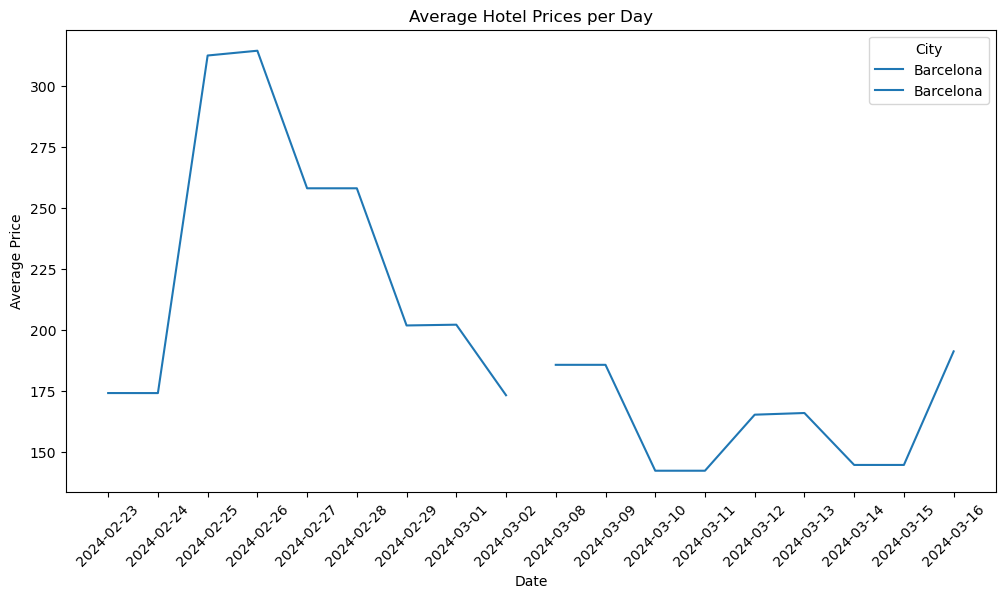

In [77]:
# Group the data by 'Start_Date' and 'City' and calculate the mean price
grouped_df_1 = df1_common.groupby(['City','Start_Date']).agg({'Price': 'mean'}).reset_index()
grouped_df_2 = df2_common.groupby(['City','Start_Date']).agg({'Price': 'mean'}).reset_index()

# Pivot the DataFrame to create a wide-form table
pivot_df_1 = grouped_df_1.pivot(index='Start_Date', columns='City', values='Price')
pivot_df_2 = grouped_df_2.pivot(index='Start_Date', columns='City', values='Price')

# Plot the average price per day per city
plt.figure(figsize=(12, 6))
sns.lineplot(data=pivot_df_1, dashes=False, palette='tab10')
sns.lineplot(data=pivot_df_2, dashes=False, palette='tab10')
plt.title('Average Hotel Prices per Day')
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.show()

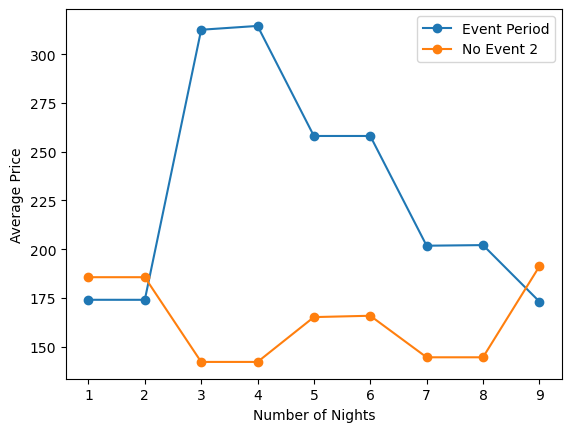

In [82]:
df1 = df1_common.copy()
df2 = df2_common.copy()

# Assuming 'Start_Date' is in string format, convert it to datetime
df1['Start_Date'] = pd.to_datetime(df1['Start_Date'])
df2['Start_Date'] = pd.to_datetime(df2['Start_Date'])

# Calculate the number of nights for each dataset
df1['Nights'] = (df1['Start_Date'] - df1['Start_Date'].min()).dt.days + 1
df2['Nights'] = (df2['Start_Date'] - df2['Start_Date'].min()).dt.days + 1

# Continue with the rest of your code
avg_price1 = df1.groupby('Nights')['Price'].mean()
avg_price2 = df2.groupby('Nights')['Price'].mean()

# Create the plot
plt.plot(avg_price1.index, avg_price1, label='Event Period', marker='o')
plt.plot(avg_price2.index, avg_price2, label='No Event 2', marker='o')

# Add labels and legend
plt.xlabel('Number of Nights')
plt.ylabel('Average Price')
plt.legend()

# Show the plot
plt.show()